#### Imports

In [15]:
import sys
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from gensim.models import CoherenceModel, LdaModel
from gensim.corpora.dictionary import Dictionary
from gensim.matutils import Sparse2Corpus

movies = pd.read_csv('./dataset/movies.csv')

#### Preprocessing

In [16]:
movies.dropna(inplace=True, subset=['description'])

custom_stop_words = {'lives', 'life', 'director', 'directed', 'film', 'films', 'filmaker',}
combined_stop_words = list(ENGLISH_STOP_WORDS.union(custom_stop_words))

# Tokenizing descriptions for dictionary
tokenized_descriptions = [doc.split() for doc in movies['description']]

# Remove stop words and vectorize to bag of words
vectorizer = CountVectorizer(stop_words=combined_stop_words, min_df=1000, max_df=0.05)
X = vectorizer.fit_transform(movies['description'])
vocab = vectorizer.get_feature_names_out()

# Convert sparse matrix to Gensim's corpus
corpus = Sparse2Corpus(X, documents_columns=False)
id2word = Dictionary(tokenized_descriptions)

# Normalize data
normalizer = Normalizer()
X_normalized = normalizer.fit_transform(X)

##### Determining Range of Topics for LDA using Log Likelihoods

In [17]:
# log_likelihoods = []
# n_topics_options = range(5, 31)  # Trying from 5 to 30 topics
# for n_topics in n_topics_options:
#     print("Starting LDA", n_topics)
#     lda = LatentDirichletAllocation(n_components=n_topics, random_state=0)
#     print("Model insantiated")
#     lda.fit(X_normalized)
#     print("Model fitted")
#     ldaScore = lda.score(X_normalized)
#     log_likelihoods.append(ldaScore)
#     print("LDA", n_topics, ":", ldaScore)

# # Plot log likelihoods
# plt.figure(figsize=(12, 6))
# plt.plot(n_topics_options, log_likelihoods, marker='o')
# plt.xlabel('Number of Topics')
# plt.ylabel('Log Likelihood')
# plt.title('Log Likelihood by Number of Topics')
# plt.show()

##### Determining Model with highest Coherence score from range of Topics

Starting 8
Model instantiated


/Users/biboy/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/biboy/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/biboy/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/biboy/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with

LDA 8 : 0.5648918530946835
Top words per topic:
Topic #0: 0.015*"biological" + 0.010*"Viola" + 0.008*"dropping" + 0.006*"challenge." + 0.006*"sunken" + 0.006*"5," + 0.006*"sorcerer" + 0.005*"bail" + 0.005*"Sutter" + 0.004*"Stanley's"
Topic #1: 0.007*"toes," + 0.007*"trend-making" + 0.007*"alternatives" + 0.006*"interrogators" + 0.006*"creation:" + 0.005*"unfaithful" + 0.005*"creature," + 0.005*"incident" + 0.005*"plane." + 0.005*"India's"
Topic #2: 0.017*"Walsh" + 0.015*"invoices" + 0.015*"brick" + 0.013*"smacks" + 0.012*"sunken" + 0.007*"Theodore," + 0.007*"unreceptive" + 0.007*"emergency" + 0.007*"hatch" + 0.006*"cross-country."
Topic #3: 0.013*"Roddy" + 0.012*"prosperous" + 0.011*"attitude" + 0.007*"Irish" + 0.007*"Julia," + 0.006*"compounded" + 0.005*"restaurant:" + 0.005*"spacecraft" + 0.005*"loner" + 0.005*"captured,"
Topic #4: 0.011*"surroundings." + 0.011*"quantum" + 0.010*"holding" + 0.010*"suspect." + 0.010*"Xtravaganza" + 0.009*"Tyrannosaurus" + 0.009*"nature" + 0.008*"prote

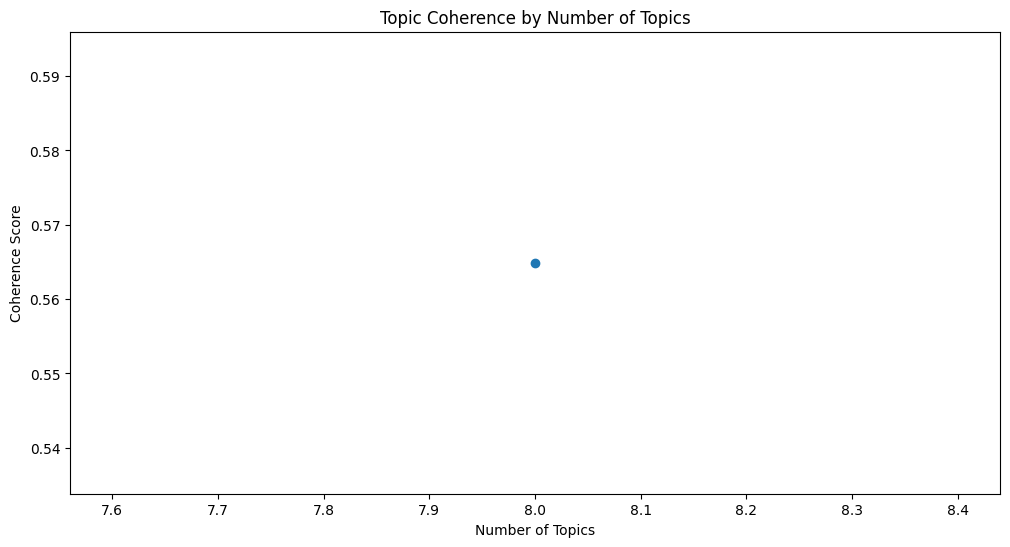

In [21]:
n_topics = 6

print("Starting", n_topics)
lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=n_topics, passes=20, random_state=0)
print("Model instantiated")

# Calculate coherence score
cm = CoherenceModel(model=lda_model, texts=tokenized_descriptions, dictionary=id2word, coherence='c_v')
coherence = cm.get_coherence()
print("LDA", n_topics, ":", coherence)

# Print top words per topic
def print_top_words(model):
    for idx, topic in model.print_topics(-1):
        print(f"Topic #{idx}: {topic}")

print("Top words per topic:")
print_top_words(lda_model, n_top_words)

# Select the model with the highest coherence score

def convert_lda_output_to_matrix(lda_output, num_topics):
    matrix = np.zeros((len(lda_output), num_topics))
    for i, doc in enumerate(lda_output):
        for topic, prob in doc:
            matrix[i, topic] = prob
    return matrix

lda2d = convert_lda_output_to_matrix(lda_model, 8)

#### Fitting to K-means Model and Determining Optimal Clusters

In [19]:
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(lda2d)
    score = silhouette_score(lda2d, kmeans.labels_)
    silhouette_scores.append(score)

# Plot silhouette scores
plt.figure(figsize=(12, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.show()

# Select the optimal number of clusters
optimal_clusters = silhouette_scores.index(max(silhouette_scores)) + 2
kmeans_final = KMeans(n_clusters=optimal_clusters, random_state=0)
kmeans_final.fit(lda2d)

ValueError: Found array with dim 3. KMeans expected <= 2.

#### Results and Plots

In [ ]:
movies['Cluster'] = kmeans_final.labels_

# Plot clusters
plt.figure(figsize=(10, 5))
plt.hist(movies['Cluster'], bins=optimal_clusters, alpha=0.7, rwidth=0.85)
plt.xlabel('Cluster')
plt.ylabel('Number of Movies')
plt.title('Distribution of Movies Across Clusters')
plt.xticks(range(optimal_clusters))
plt.show()